### Asistente con Nodos de recuperacion de archivos opcionales y almacenamiento de vectores en sqlite

In [1]:
#segmentacion de docs
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

#Vector store
import sqlite3
from langchain_community.vectorstores import SQLiteVec


# llms
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai.embeddings import OpenAIEmbeddings

#Langgraph modules
from langgraph.graph import START, StateGraph
from langchain_core.prompts import PromptTemplate

# python common modules
from IPython.display import Image, display
from typing_extensions import Annotated, List, TypedDict
from typing import Literal
from dotenv import load_dotenv
from pathlib import Path

import os

load_dotenv()
#

base_dir = Path.cwd()
leyes_dir = base_dir / "leyes"  # Adjust this path based on your actual directory structure

# If leyes_dir doesn't exist, try going up one level
if not leyes_dir.exists():
    leyes_dir = base_dir.parent / "leyes"

Cargamos el modelo

In [2]:
openai_api_key = os.getenv("DEEPSEEK_API_KEY")
openai_base_url = os.getenv("DEEPSEEK_API_URL")
openai_model = os.getenv("LLM_MODEL")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(
    # base_url=openai_base_url,
    # api_key=openai_api_key,
    model= "gpt-4o",
    temperature=0.5, 
)

definimos el prompt a usar

In [3]:
template = """ Responde exclusivamente en español. 
Eres un asistente legal que puede responder preguntas sobre el 
reglamento de tránsito boliviano.
Usa solamente información de la referencia para responder. 
En caso de que no encuentres la respuesta en la referencia, responde con "No tengo información sobre eso".
En tu respuesta referencia el articulo que corresponda a tu respuesta.

Usa la siguiente información como referencia: 
{context}

Responde a la siguiente pregunta:
{question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

Hacemos la recuperacion de documentos una herramienta para que sea opcionalmente llamado por el agente

In [4]:
from langchain_core.tools import tool

numero_docs_recuperados: int  = 4

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
)

import json
from pathlib import Path

# Load categories dictionary
with open(Path.cwd() / "categorias_sinonimos_bolivia.json", "r", encoding="utf-8") as f:
    categories_dict = json.load(f)
    
def categorize_text(text):
    """Tag text with categories based on term matches."""
    text_lower = text.lower()
    matched_categories = set()
    
    for category, terms in categories_dict.items():
        for term in terms:
            if term.lower() in text_lower:
                matched_categories.add(category)
                break
    
    return list(matched_categories)

@tool(response_format="content_and_artifact")
def recuperarDocs(query: str):
    """Retrieve information related to a query."""
    # Create a new connection each time the function is called
    db_path_str = str(base_dir / "Database/leyes.db")
    
    query_categories = categorize_text(query)
    
    # Create a new vector store with a new connection
    vector_store = SQLiteVec(
    table="leyes",
    connection=None,
    embedding=embeddings,
    db_file=db_path_str,
    )   

    retrieved_docs = vector_store.similarity_search(query, k=numero_docs_recuperados)
    
     # Optional: You could re-rank docs based on category overlap
    if query_categories:
        retrieved_docs.sort(key=lambda doc: len(set(doc.metadata.get("categories", [])) & 
                                             set(query_categories)), reverse=True)
    
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

tools = [recuperarDocs]
llm_with_tools = llm.bind_tools(tools)

e:\Code\Python\Asistente-Legal-API\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creamos el nodo donde se usará la herramienta

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
   content="""Responde exclusivamente en español. 
      Eres un asistente legal que responde preguntas sobre el reglamento de tránsito boliviano.
      Al usar la herrmaienta de recuperacion, haz el query con menor cantidad de tokens posible.
      En caso de que no encuentres la respuesta en la referencia, responde con "No tengo información sobre eso".
      En tu respuesta referencia el articulo que corresponda a tu respuesta."""
   )

# Node
def recuperar_o_responder(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Definimos el grafo

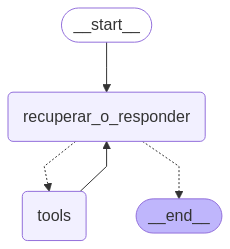

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
grafo = StateGraph(MessagesState)

# Define nodes: these do the work
grafo.add_node("recuperar_o_responder", recuperar_o_responder)
grafo.add_node("tools", ToolNode(tools)) # cargando la lista de herramientas

# Define edges: these determine how the control flow moves
grafo.add_edge(START, "recuperar_o_responder")
grafo.add_conditional_edges(
    "recuperar_o_responder",
    tools_condition,
)
grafo.add_edge("tools", "recuperar_o_responder")
react_graph = grafo.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Probamos con mensajes guardados

In [7]:
messages = [HumanMessage(content="cual es la velocidad maxima permitida")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

cual es la velocidad maxima permitida
================================== Ai Message ==================================
Tool Calls:
  recuperarDocs (call_awctiyv9eNRXQronU2ojGPtH)
 Call ID: call_awctiyv9eNRXQronU2ojGPtH
  Args:
    query: velocidad maxima permitida
================================= Tool Message =================================
Name: recuperarDocs

Source: {'source': 'e:\\Code\\Python\\Asistente-Legal-API\\App\\leyes\\1978-BO-RE-RS187444(1).txt', 'categories': ['Vehículos', 'Velocidad', 'Justicia / Procedimiento', 'Pasajeros', 'Peatones', 'Policía / Tránsito']}
Content: 1. Llevar mayor número de pasajeros que el permitido por la autoridad.
  2. Cobrar una tarifa mayor a la legalmente autorizada.
  3. Fumar, conversar o distraerse al conducir el vehículo.
  4. Negarse a transportar estudiantes (escolares) o a los funcionarios de la
     Policía de Tránsito.
  5. Admitir en el vehículo indiv